<a href="https://colab.research.google.com/github/Justworkname/6367_project/blob/main/Regression_V2_smaller_deltas_saving_failing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression Model V2_smaller_deltas_testing_save_failed



## Import

In [1]:
!pip install -q torchinfo

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.optim as optim
from torchvision import datasets, transforms
from torchinfo import summary
import numpy as np
import pandas as pd
import os
from PIL import Image
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import torch.optim.lr_scheduler as lr_scheduler

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

# this creates a link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

Mounted at /content/gdrive
'10 19 2023 meeting.gslides'
'6 16 2023 Meeting.gslides'
 6367
 6367_project
'6367 Project presentation.gslides'
'7 12 2023 meeting.gslides'
 7340
'8 17 2023 meeting.gslides'
'8 30 2023 meeting.gslides'
'9 06 2023 meeting - Bar chart 1.gsheet'
'9 06 2023 meeting - Column chart 1 (1).gsheet'
'9 06 2023 meeting - Column chart 1 (2).gsheet'
'9 06 2023 meeting - Column chart 1.gsheet'
'9 06 2023 meeting.gslides'
'9 20 2023 meeting.gslides'
'9 28 2023 meeting.gslides'
'AI in Breast Cancer in Medical Imaging.gslides'
 AI_MB
 AI_MB_3D
'Colab Notebooks'
 customTF2
 Data_Vision_Transformer
 fakeImages
 Grad_documents
'Invited Lecture 2.gdoc'
'Invited Lecture 5.gdoc'
'Invited lecture 6.gdoc'
'Invited Lecture 7.gdoc'
 Invited_lecture_oct_10.gdoc
'Invited Lecture October 3rd.gdoc'
'Invited Lecture September 19th.gdoc'
'My Drive'
'Presentation Evaluation sep 19.gdoc'
'QE Key points.gdoc'
'Regression testing.gdoc'
'Regression testing multiple deltas.gdoc'
 Seminar
 Ultraso

## Hyperparameters

In [4]:
num_epochs=5000
input_dim = 54
output_dim = 1
hidden_dim = 3721
dropout=0.01

## Load

In [5]:
# Load the CSV file into a DataFrame
csv_file_path = '/content/gdrive/MyDrive/6367_project/data_v2.csv'
df = pd.read_csv(csv_file_path)
df.fillna(0,inplace=True)
df = df.loc[(df != 0).all(axis=1)] # filter if want

train_patients = ['3', '4', '5', '6', '8', '9','10', '11','13','14','16','19','20','21','23']
test_patients = ['25']

df['Patient #'] = df['Patient #'].astype(str)

df_train=df[df['Patient #'].isin(train_patients)]
df_test=df[df['Patient #'].isin(test_patients)]

# Convert to desired data shape
y_train = df_train['Delta Plq Area'] #change with desired prediction
X_train = df_train.drop(columns=['Delta Plq Area','Patient #','Total FU Plq Area','VHIVUS FU img ind','CC FU Area','CC FU Circum Cov.','CC FU max thick',
                     'NC FU Area','NC FU max thick','FI FU Area','FI FU Circum Cov.','FI FU max thick','FF FU Area','FF FU Circum Cov.','FF FU max thick',
                     'VHIVUS BL img ind','BL Pat FRS','BL Pat LDL','BL Pat FFR','BL Pat EEMV','BL Pat BMI','BL Pat BUR']) #data to exclude

y_test = df_test['Delta Plq Area'] #change with desired prediction
X_test = df_test.drop(columns=['Delta Plq Area','Patient #','Total FU Plq Area','VHIVUS FU img ind','CC FU Area','CC FU Circum Cov.','CC FU max thick',
                     'NC FU Area','NC FU max thick','FI FU Area','FI FU Circum Cov.','FI FU max thick','FF FU Area','FF FU Circum Cov.','FF FU max thick',
                     'VHIVUS BL img ind','BL Pat FRS','BL Pat LDL','BL Pat FFR','BL Pat EEMV','BL Pat BMI','BL Pat BUR'])

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)
y_train = y_train.view(-1)
y_test = y_test.view(-1)

## Model

In [6]:
class RegressionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout):
        super(RegressionModel, self).__init__()

        # Define the layers
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, 100)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(100, output_dim)
        #self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        # Forward pass
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        #x = self.dropout(x)
        x = self.fc3(x)
        return x

In [7]:
model = RegressionModel(input_dim, hidden_dim, output_dim,dropout)

In [8]:
summary(model)

Layer (type:depth-idx)                   Param #
RegressionModel                          --
├─Linear: 1-1                            204,655
├─ReLU: 1-2                              --
├─Linear: 1-3                            372,200
├─Linear: 1-4                            101
Total params: 576,956
Trainable params: 576,956
Non-trainable params: 0

In [9]:
# Mean Squared Error loss
criterion = nn.SmoothL1Loss()
# Apply optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)
# Learning rate scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.5)

## Training

In [10]:
# List for Loss and R squared
losses = []
val_losses = []
r2_values = []
r2_validation = []

# Training loop
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train)
    outputs = outputs.squeeze(dim=1)

    # Compute the loss
    ## Could consider Huber Loss
    loss = criterion(outputs, y_train)

    # Backpropagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Learning rate annealing
    scheduler.step()

    # Calculate R-squared
    y_pred = outputs.detach().numpy()
    r2 = r2_score(y_train.numpy(), y_pred)

    # Store loss and R-squared values for this epoch
    losses.append(loss.item())
    r2_values.append(r2)

    # Testing predictions
    y_pred = model(X_test).detach().numpy()
    # Calculate R-squared accuracy on the test data
    r2_test = r2_score(y_test.numpy(), y_pred)
    r2_validation.append(r2_test)
    val_out = model(X_test)
    val_out = val_out.squeeze(dim=1)
    val_loss = criterion(val_out,y_test)
    val_losses.append(val_loss.item())

    print('Epoch [{}/{}], Loss: {:.4f}, R-squared: {:.4f},Validation_loss:{:,.4f}, Validation R_squared:{:,.4f}'.format(epoch+1, num_epochs, loss.item(), r2,val_loss.item(),r2_test))

Epoch [1/5000], Loss: 0.2956, R-squared: -0.1438,Validation_loss:0.1842, Validation R_squared:-0.3281
Epoch [2/5000], Loss: 0.2864, R-squared: -0.1059,Validation_loss:0.1838, Validation R_squared:-0.3264
Epoch [3/5000], Loss: 0.2794, R-squared: -0.0770,Validation_loss:0.1829, Validation R_squared:-0.3208
Epoch [4/5000], Loss: 0.2739, R-squared: -0.0543,Validation_loss:0.1817, Validation R_squared:-0.3129
Epoch [5/5000], Loss: 0.2694, R-squared: -0.0360,Validation_loss:0.1804, Validation R_squared:-0.3037
Epoch [6/5000], Loss: 0.2658, R-squared: -0.0212,Validation_loss:0.1789, Validation R_squared:-0.2933
Epoch [7/5000], Loss: 0.2628, R-squared: -0.0090,Validation_loss:0.1775, Validation R_squared:-0.2835
Epoch [8/5000], Loss: 0.2604, R-squared: 0.0009,Validation_loss:0.1760, Validation R_squared:-0.2734
Epoch [9/5000], Loss: 0.2584, R-squared: 0.0092,Validation_loss:0.1747, Validation R_squared:-0.2638
Epoch [10/5000], Loss: 0.2567, R-squared: 0.0162,Validation_loss:0.1733, Validation 

## Plots

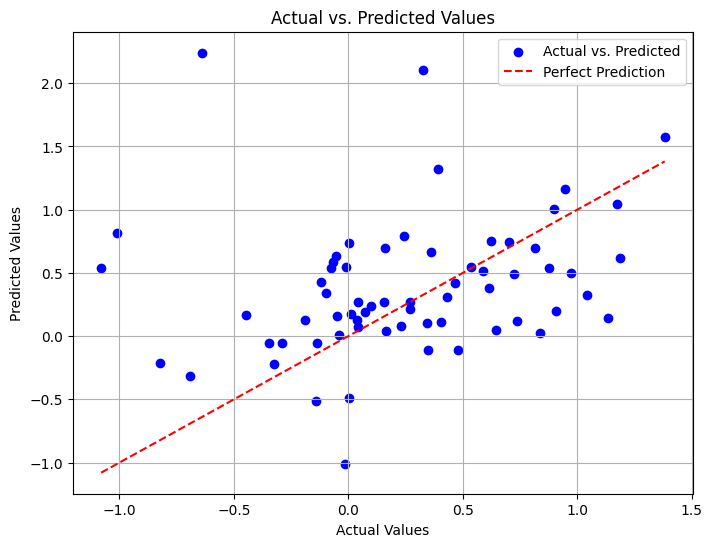

In [11]:
# Create a scatter plot of actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', label='Actual vs. Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.grid(True)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', label='Perfect Prediction')
plt.legend()

# Display the plot
plt.show()

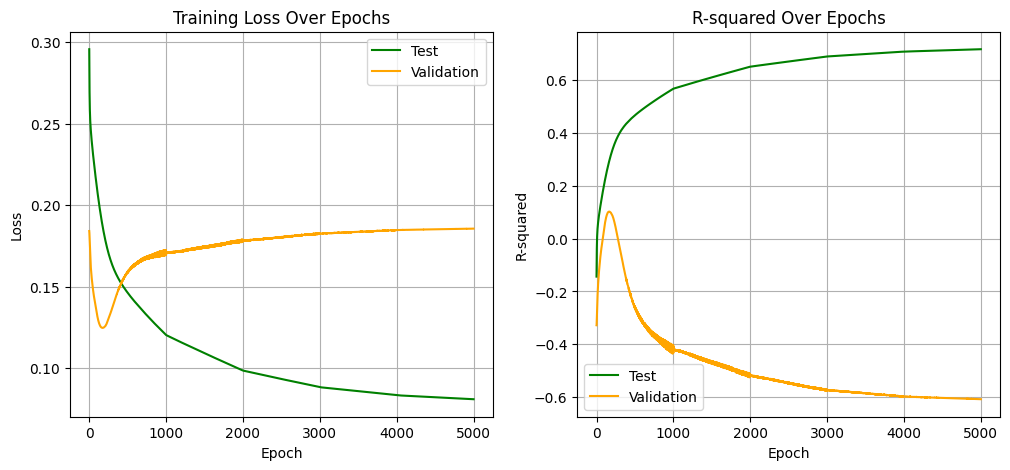

In [12]:
# Create a plot for the loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), losses, label='Test', color='green')
plt.plot(range(num_epochs), val_losses, label='Validation', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)

# Create a plot for R-squared
plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), r2_values, label='Test', color='green')
plt.plot(range(num_epochs), r2_validation, label='Validation', color='orange')
plt.xlabel('Epoch')
plt.ylabel('R-squared')
plt.title('R-squared Over Epochs')
plt.legend()
plt.grid(True)

# Display Plot
plt.show()

## Gradient

In [13]:
#extract grad
parameter_importance = model.fc1.weight.grad

In [14]:
# Convert the parameter_importance tensor to a NumPy array
parameter_importance_img = parameter_importance.detach().numpy()
# Normalize the values to [0, 1]
min_val = parameter_importance_img.min()
max_val = parameter_importance_img.max()

parameter_importance_img = (parameter_importance_img - min_val) / (max_val - min_val)
parameter_importance_img = np.floor(parameter_importance_img*255)

Display

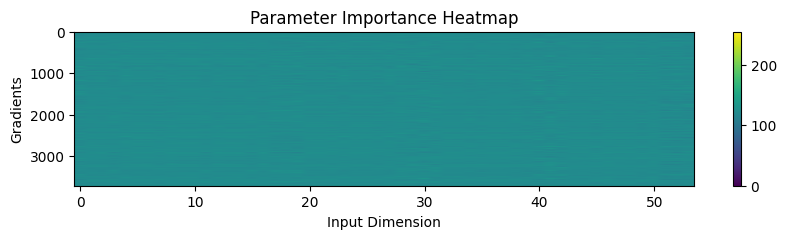

In [15]:
# Create a heatmap
plt.figure(figsize=(10, 2))
plt.imshow(parameter_importance_img, cmap='viridis', aspect='auto')
plt.colorbar()
plt.title('Parameter Importance Heatmap')
plt.xlabel('Input Dimension')
plt.ylabel('Gradients')
plt.show()

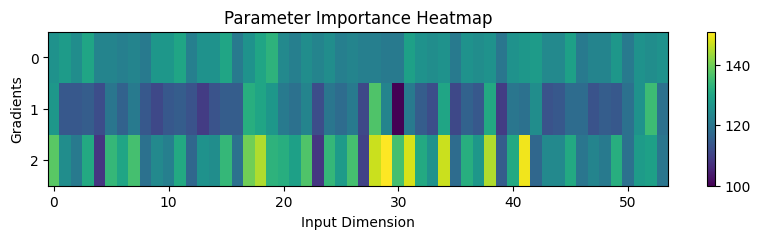

In [16]:
data_row=0
# Plot heatmap
plt.figure(figsize=(10, 2))
plt.imshow(parameter_importance_img[0+data_row:3+data_row,:], cmap='viridis', aspect='auto')
plt.colorbar()
plt.title('Parameter Importance Heatmap')
plt.xlabel('Input Dimension')
plt.ylabel('Gradients')
plt.show()